In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
import pandas as pd
import seaborn as sns

import is3_broker_rl
from is3_broker_rl.api.dto import Action

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
sns.set_style("white")

In [2]:
DATA_DIR = Path(is3_broker_rl.__file__).parent.parent / "data"

In [3]:
# Papermill parameter cell
# Name of the directory to analyse. Should contain consumption_action.csv and consumption_reward.csv.
ANALYSIS_DIR_NAME = ""

In [4]:
# Parameters
ANALYSIS_DIR_NAME = "trial2_test2"


In [5]:
ANALYSIS_DIR = DATA_DIR / ANALYSIS_DIR_NAME

In [6]:
df_action = pd.read_csv(ANALYSIS_DIR / "consumption_action.csv")
df_reward = pd.read_csv(ANALYSIS_DIR / "consumption_reward.csv")

In [7]:
ACTION_VALUE_MAPPING = {a.name: a.value for a in Action}

In [8]:
# Fixes the issue that the experiment scheduler always assigns the same gameId
def write_unique_game_id(df):
    new_game_start_indices = df[df["timeslot"] < df["timeslot"].shift()].index
    df.loc[: new_game_start_indices[0], "gameId"] = f"game0"
    for i in range(len(new_game_start_indices) - 1):
        df.loc[new_game_start_indices[i] : new_game_start_indices[i + 1], "gameId"] = f"game{i + 1}"
    df.loc[new_game_start_indices[-1] :, "gameId"] = f"game{len(new_game_start_indices)}"

In [9]:
write_unique_game_id(df_reward)
write_unique_game_id(df_action)

In [10]:
def plot_action_counts(df_action):
    fig, ax = plt.subplots(figsize=(16, 9))
    sns.countplot(x="action", data=df_action, ax=ax, order=ACTION_VALUE_MAPPING.values())
    ax.set_xticklabels(ACTION_VALUE_MAPPING.keys())
    ax.set_xlabel("Action type")
    ax.set_ylabel("Count")
    ax.set_title("Action distribution")

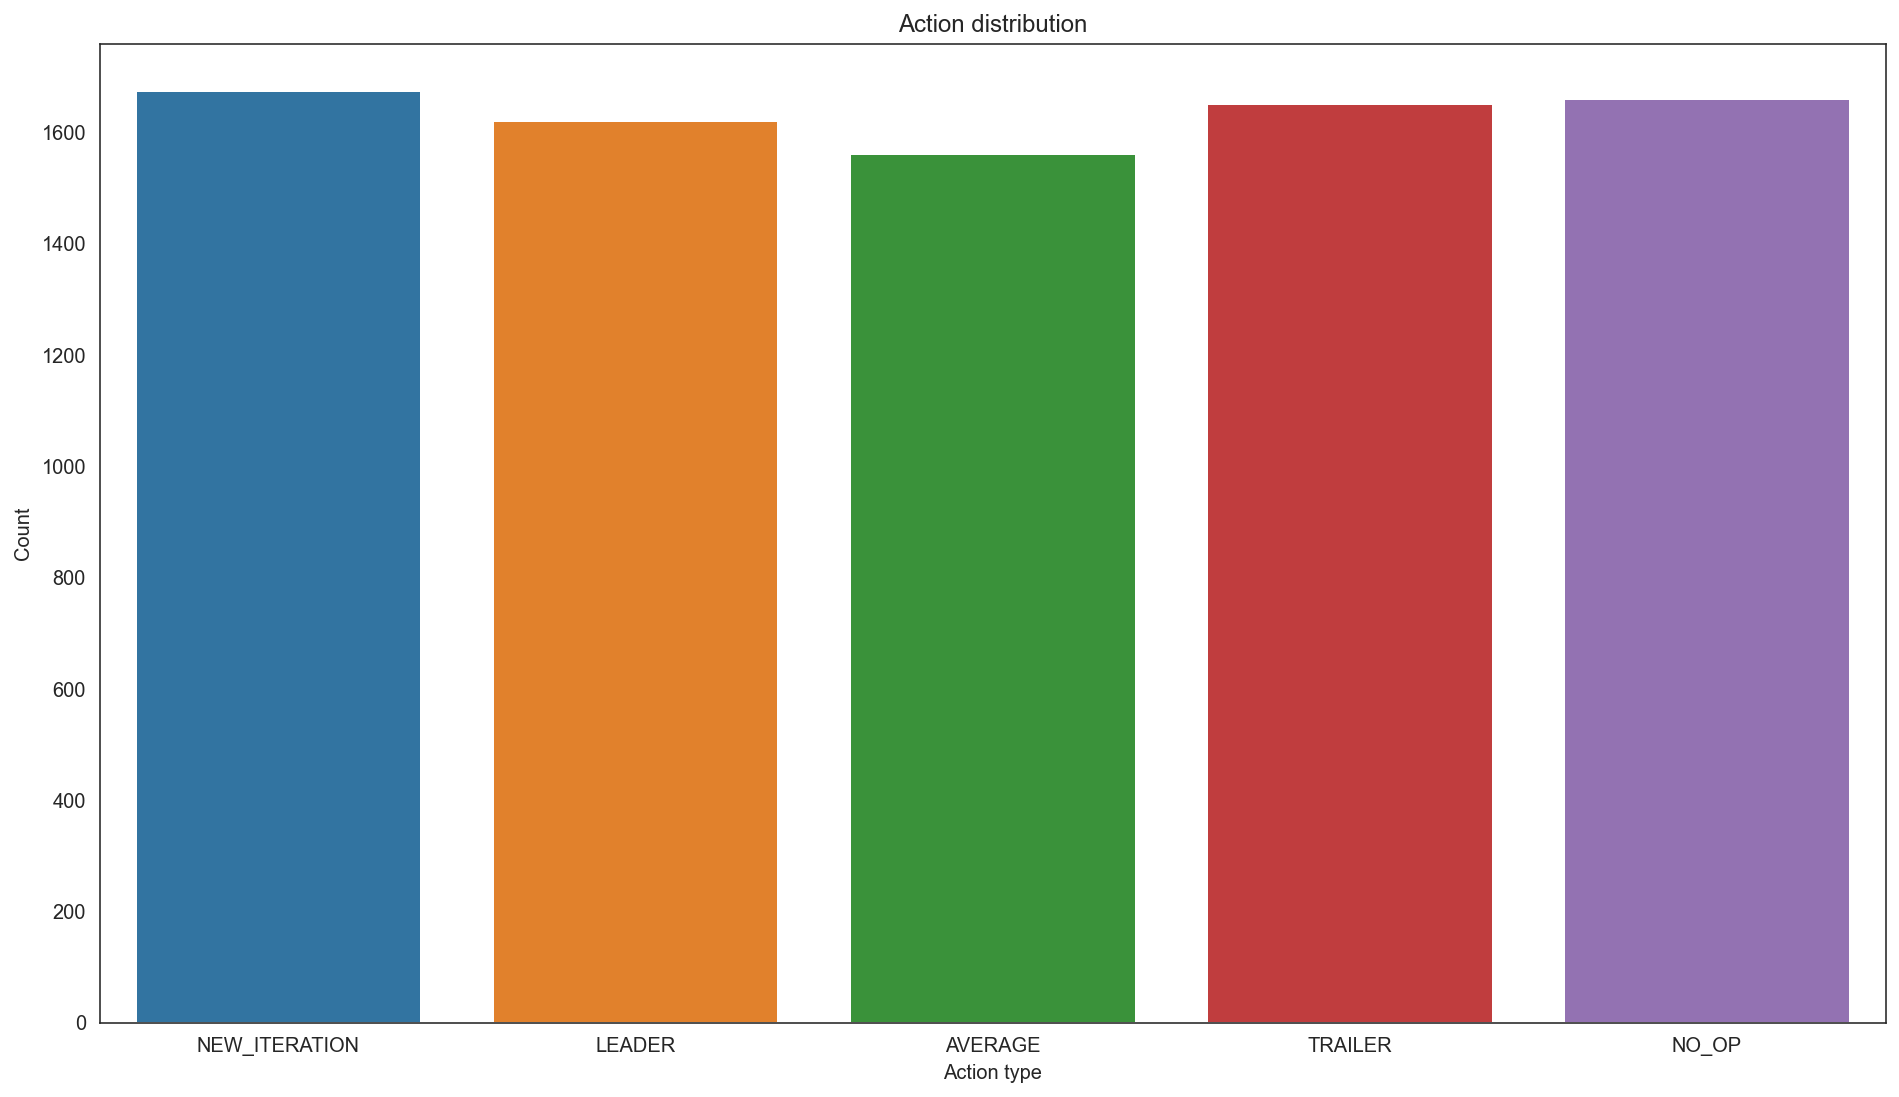

In [11]:
plot_action_counts(df_action)

In [12]:
def plot_action_count_over_time(df_action):
    fig, axs = plt.subplots(figsize=(21, 14), nrows=len(ACTION_VALUE_MAPPING))
    action_value_counts = (
        df_action[["gameId", "action"]]
        .groupby(["gameId", "action"], sort=False)
        .size()
        .unstack(fill_value=0)
        .reset_index(drop=True)
    )
    for i, action_value in enumerate(ACTION_VALUE_MAPPING.values()):
        ax = axs.flat[i]
        sns.lineplot(data=action_value_counts[action_value], ax=ax)
        ax.set_title(f"Number of action={list(ACTION_VALUE_MAPPING.keys())[action_value]} over time for each game")
        ax.set_xlabel("Game number")
        ax.set_ylabel("Action count")
    fig.tight_layout()

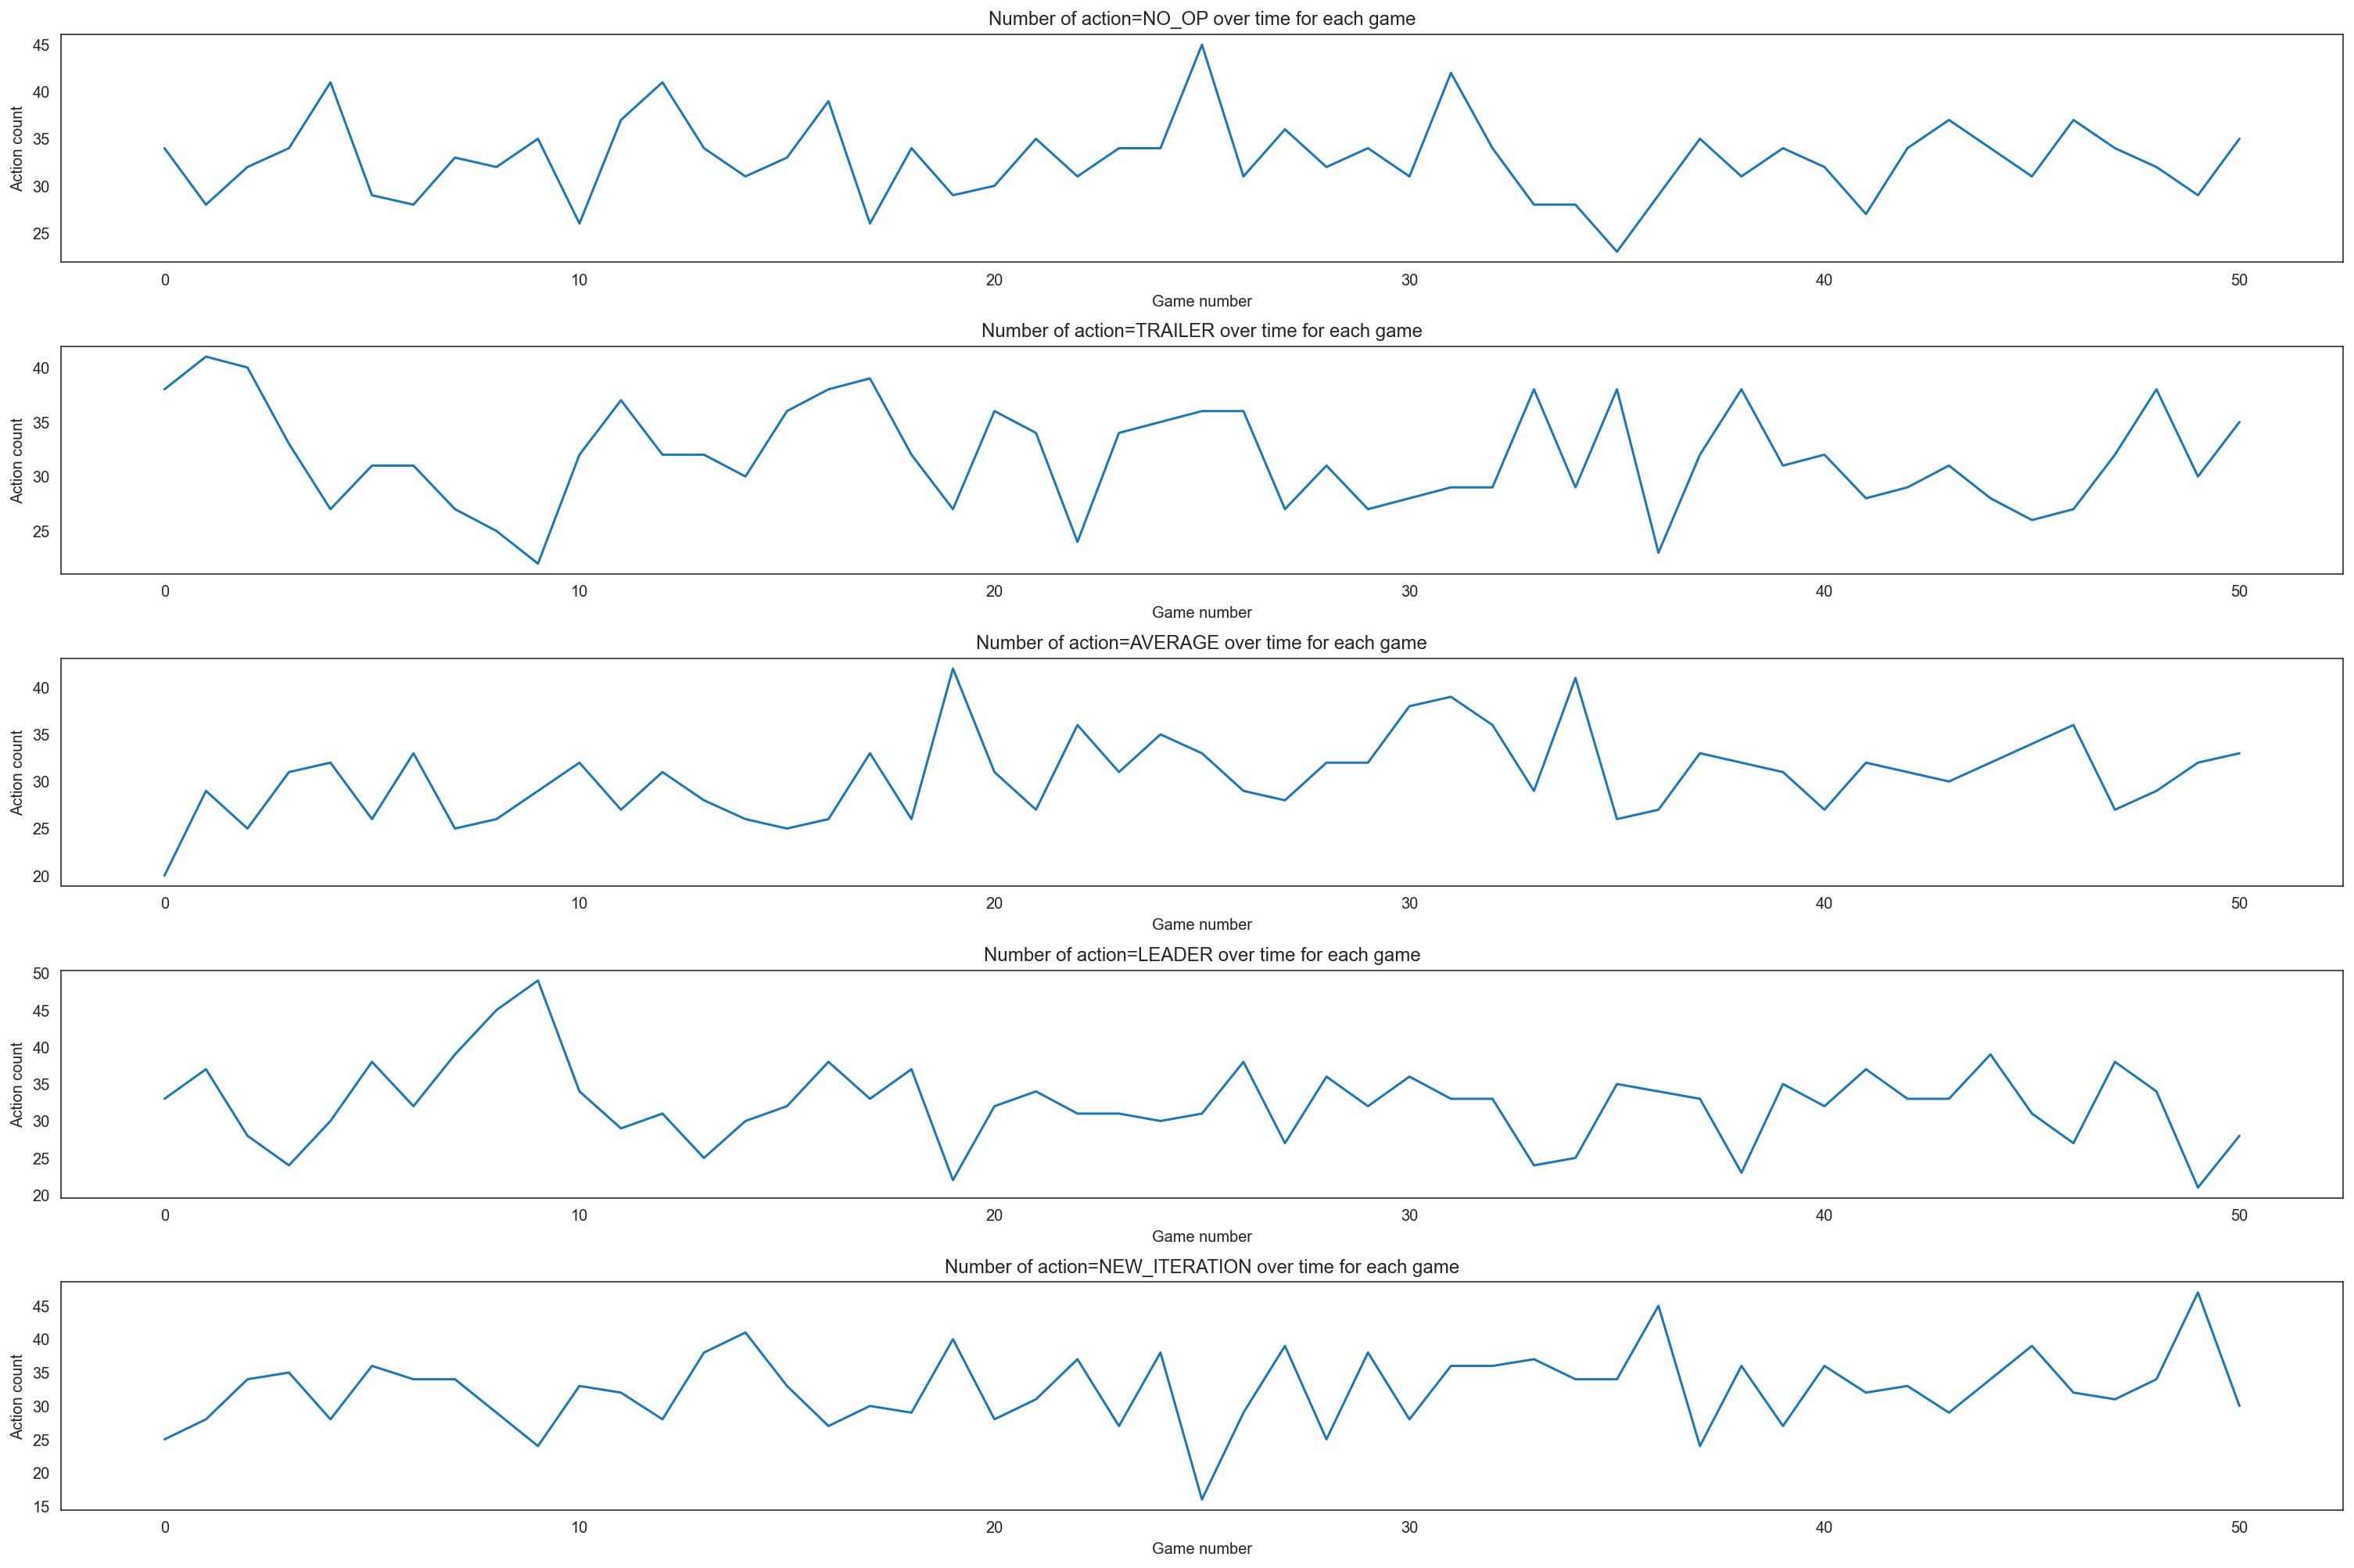

In [13]:
plot_action_count_over_time(df_action)

In [14]:
def plot_timestep_reward(df_reward):
    window_size = 168
    fig, ax = plt.subplots(figsize=(16, 9))
    sns.lineplot(data=df_reward["reward"].rolling(window_size).mean(), ax=ax)
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Reward")
    ax.set_title(f"Rolling mean reward with window size {window_size}")

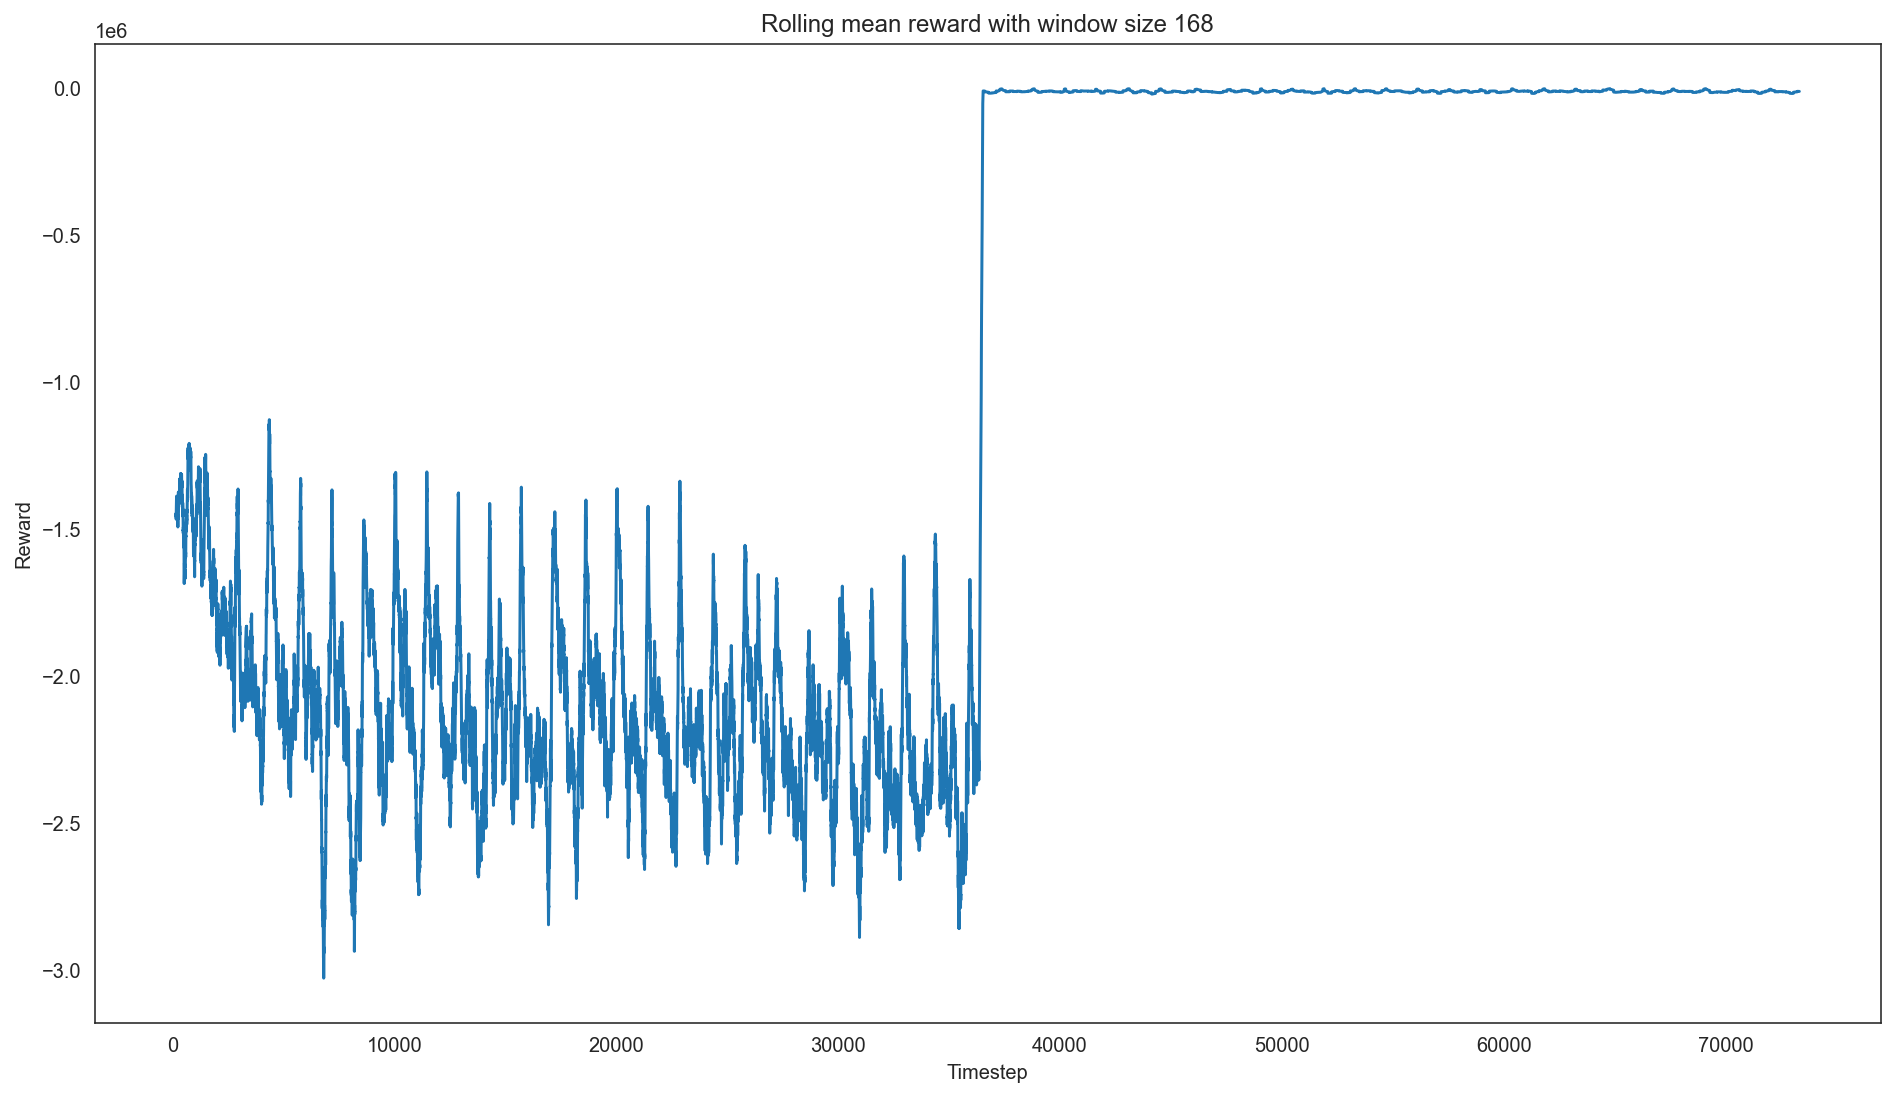

In [15]:
plot_timestep_reward(df_reward)

In [16]:
def plot_episode_reward(df_reward, df_action):
    fig, ax = plt.subplots(figsize=(21, 11))
    df_mean_episode_reward = df_reward.groupby("episode_id", sort=False).mean().reset_index()
    df_max_episode_reward = df_reward.groupby("episode_id", sort=False).max().reset_index()
    df_min_episode_reward = df_reward.groupby("episode_id", sort=False).min().reset_index()
    sns.lineplot(
        x=df_mean_episode_reward.index, y="reward", data=df_mean_episode_reward, ax=ax, label="Mean episode reward"
    )
    sns.lineplot(
        x=df_max_episode_reward.index, y="reward", data=df_max_episode_reward, ax=ax, label="Max episode reward"
    )
    sns.lineplot(
        x=df_min_episode_reward.index, y="reward", data=df_min_episode_reward, ax=ax, label="Min episode reward"
    )
    df_episode_game_id = df_reward.groupby("episode_id", sort=False)["gameId"].first().reset_index()
    ax.vlines(
        df_episode_game_id[df_episode_game_id["gameId"].shift() != df_episode_game_id["gameId"]].index,
        0,
        1,
        transform=ax.get_xaxis_transform(),
        colors="r",
        alpha=0.3,
        label="New game",
    )
    ax.set_xlabel("Episode")
    ax.set_ylabel("Aggregated reward")
    ax.legend()
    ax.set_title(f"Episode reward (N_EPISODES: {df_reward['episode_id'].nunique()}, N_TIMESTEPS: {len(df_action)})")
    ax.margins(x=0)

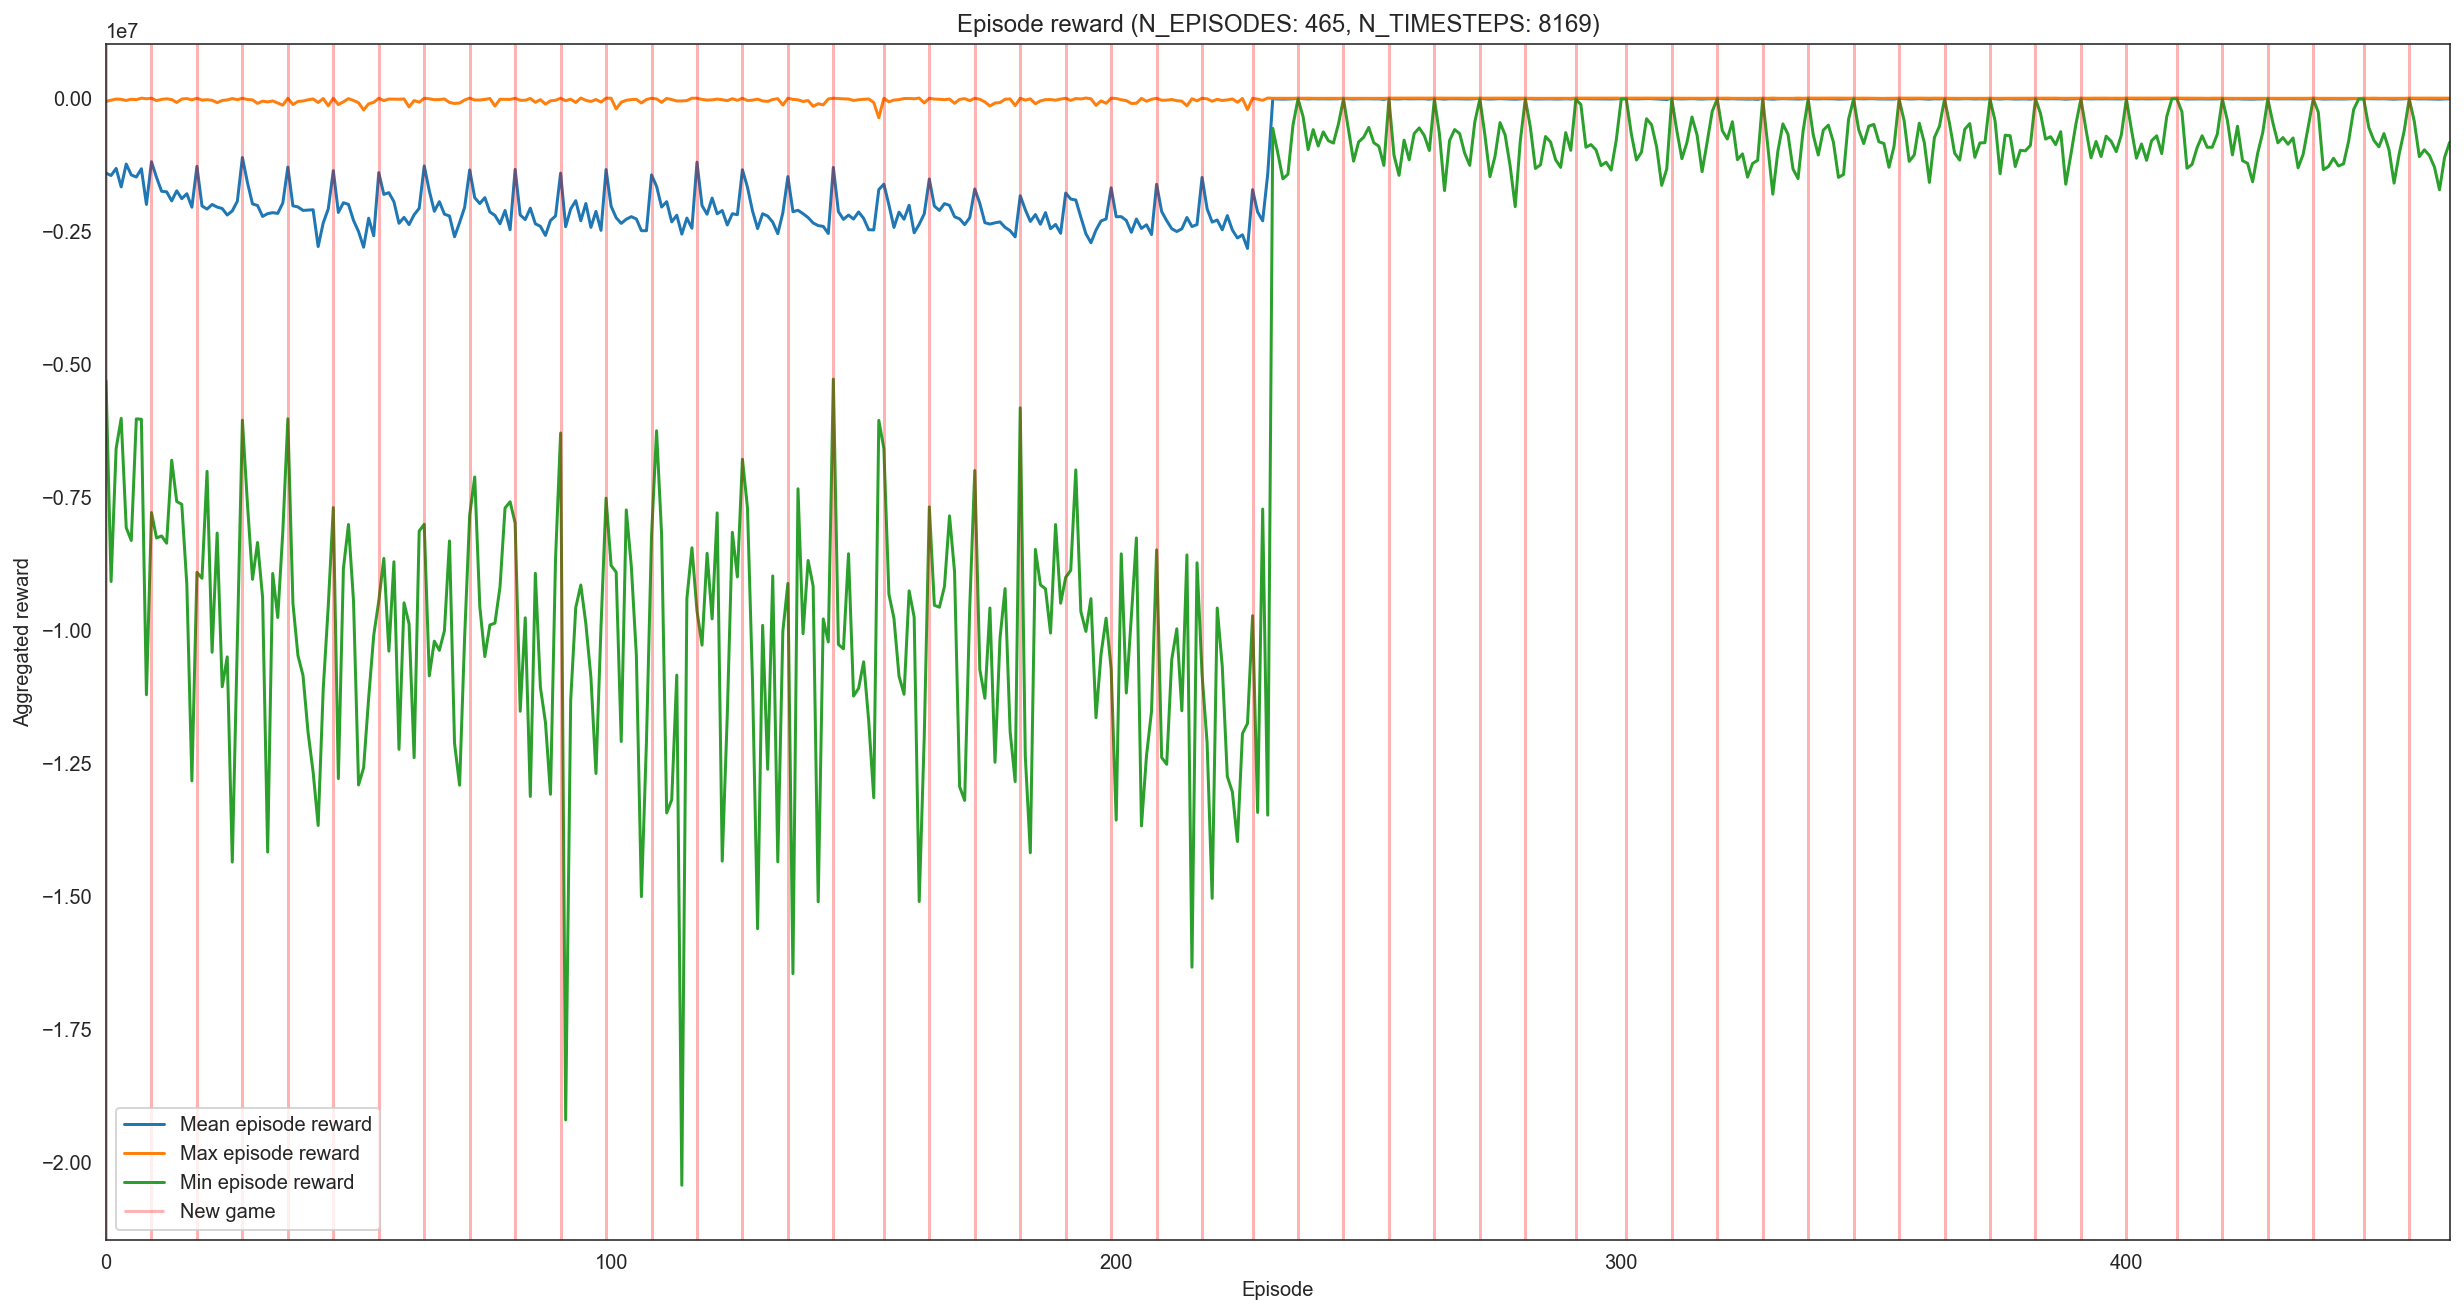

In [17]:
plot_episode_reward(df_reward, df_action)

In [18]:
def plot_mean_episode_reward_reg(df_reward, df_action):
    fig, ax = plt.subplots(figsize=(21, 11))
    df_mean_episode_reward = df_reward.groupby("episode_id", sort=False).mean().reset_index()
    sns.regplot(
        x=df_mean_episode_reward.index,
        y="reward",
        data=df_mean_episode_reward,
        scatter=True,
        marker=".",
        ax=ax,
        label="Mean episode reward",
        line_kws={"label": "OLS fit"},
    )
    df_episode_game_id = df_reward.groupby("episode_id", sort=False)["gameId"].first().reset_index()
    ax.vlines(
        df_episode_game_id[df_episode_game_id["gameId"].shift() != df_episode_game_id["gameId"]].index,
        0,
        1,
        transform=ax.get_xaxis_transform(),
        colors="r",
        alpha=0.3,
        label="New game",
    )
    ax.set_xlabel("Episode")
    ax.set_ylabel("Aggregated reward")
    ax.legend()
    ax.set_title(
        f"Mean episode reward (N_EPISODES: {df_reward['episode_id'].nunique()}, N_TIMESTEPS: {len(df_action)})"
    )
    ax.margins(x=0)

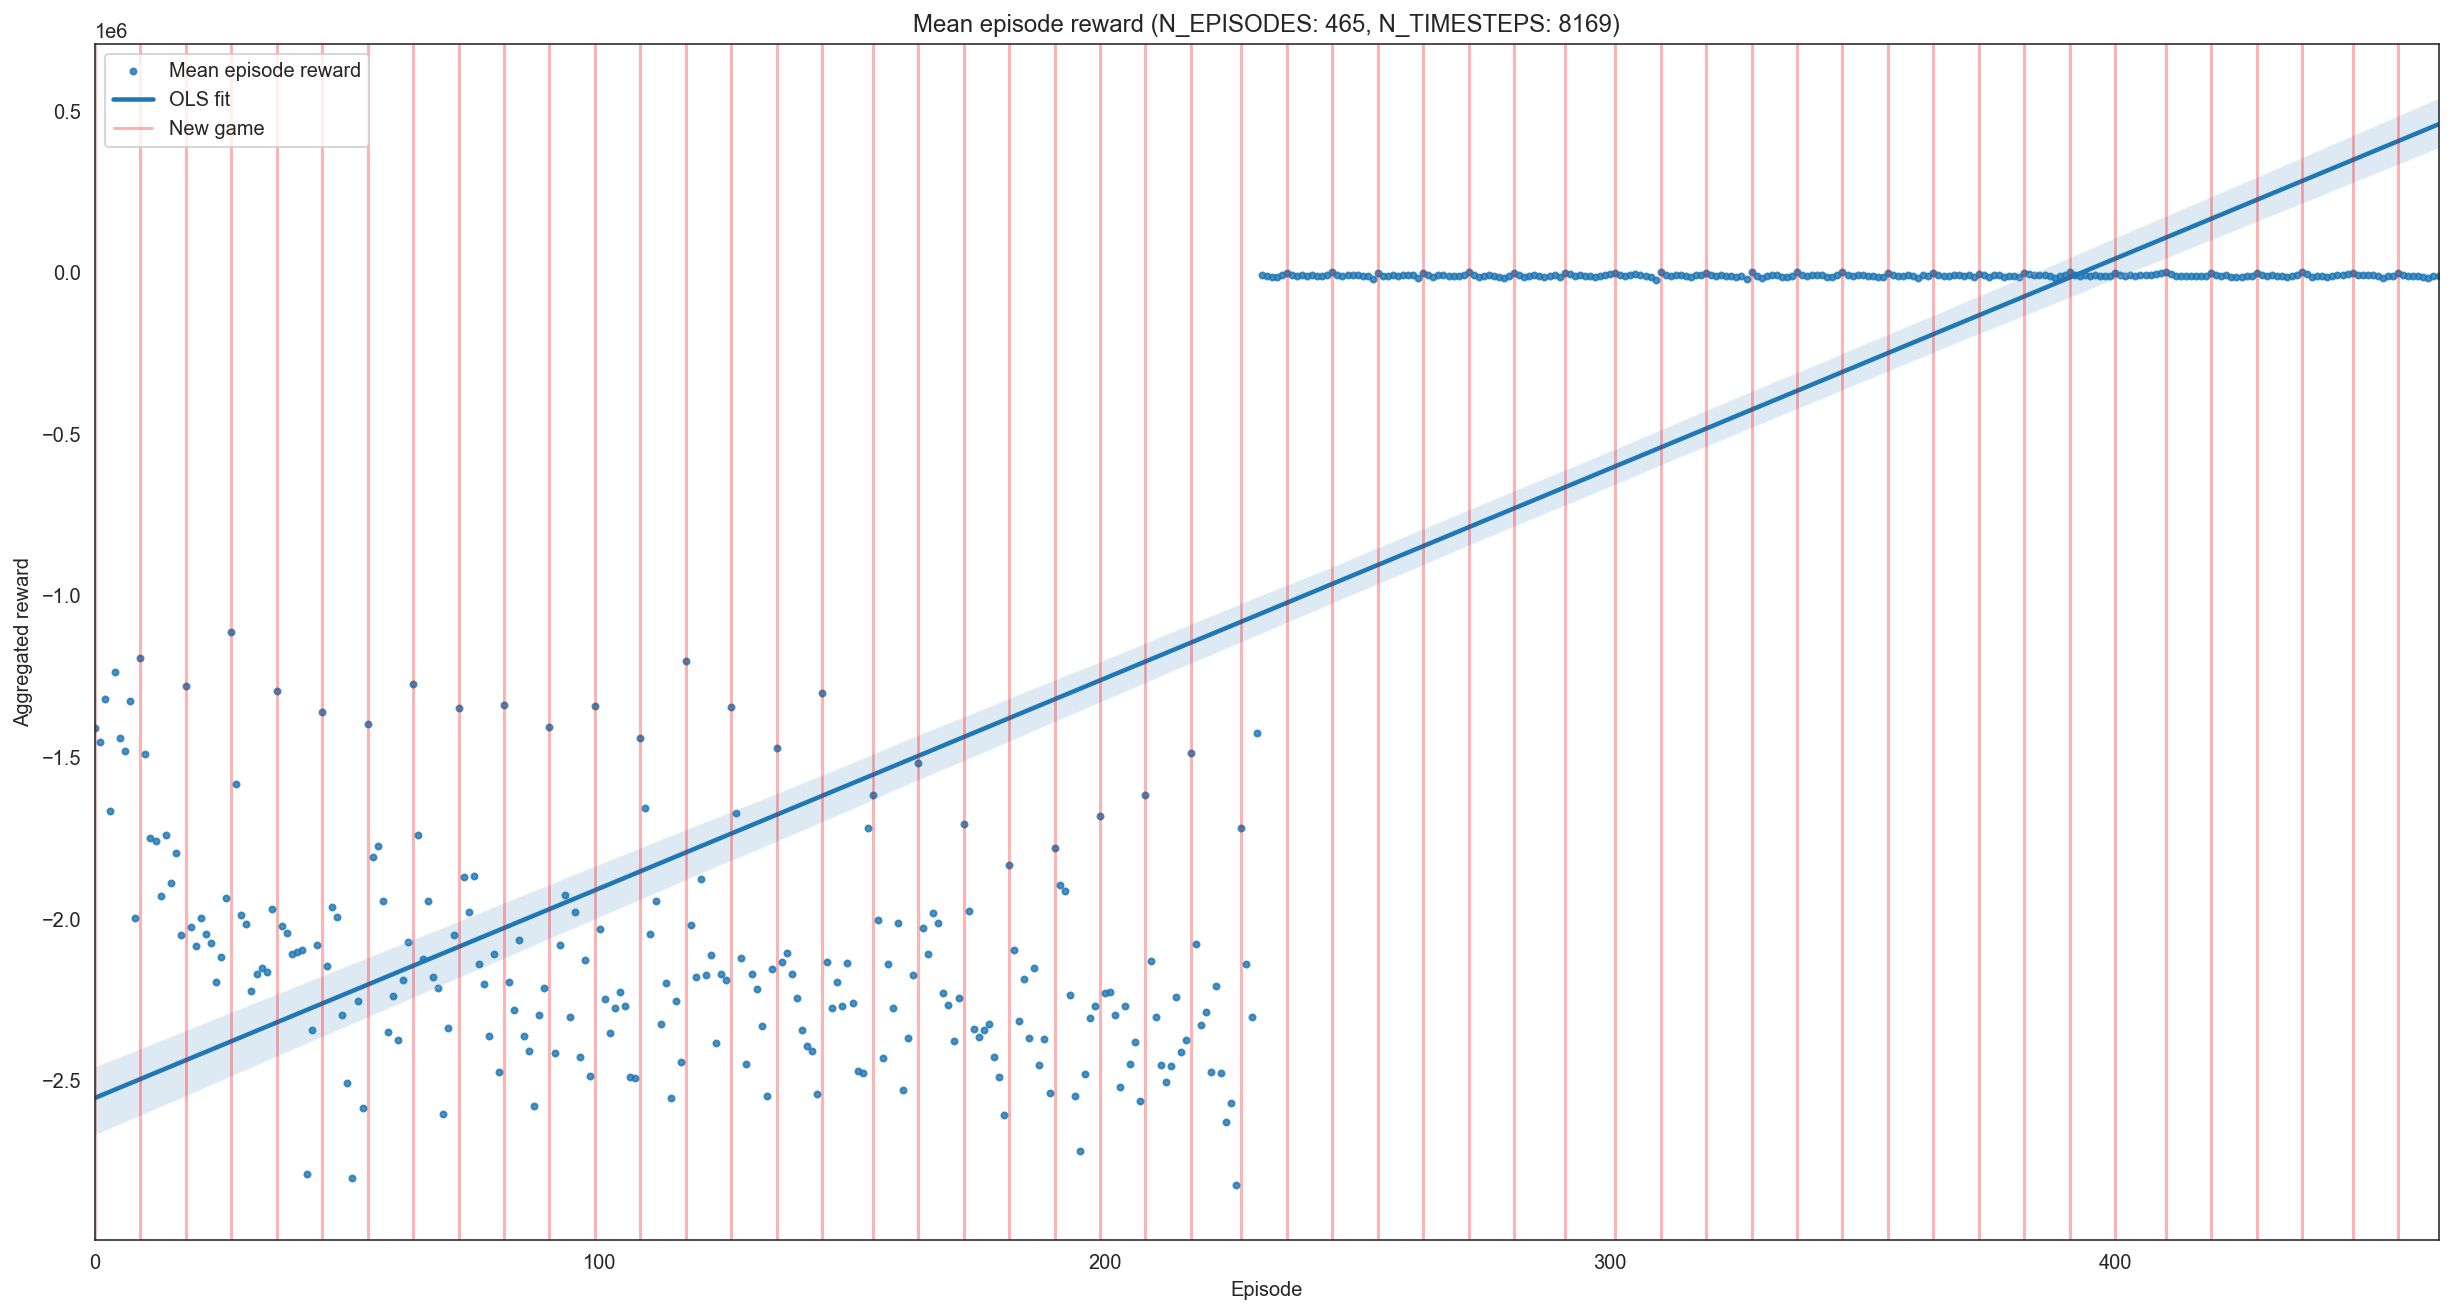

In [19]:
plot_mean_episode_reward_reg(df_reward, df_action)

In [20]:
def plot_mean_reward_per_action(df_reward):
    fig, ax = plt.subplots(figsize=(21, 11))
    df_reward = df_reward.copy().dropna()  # Avoid overwriting original df
    df_reward["last_action"] = df_reward["last_action"].astype(np.uint8)
    mean_reward_per_action = df_reward[["last_action", "reward"]].groupby("last_action").mean()
    sns.barplot(
        x=mean_reward_per_action.index,
        y="reward",
        data=mean_reward_per_action,
        ax=ax,
        order=ACTION_VALUE_MAPPING.values(),
    )
    ax.set_xticklabels(ACTION_VALUE_MAPPING.keys())
    ax.set_xlabel("Action")
    ax.set_ylabel("Mean reward associated with the action")
    ax.set_title(f"Mean reward per action")

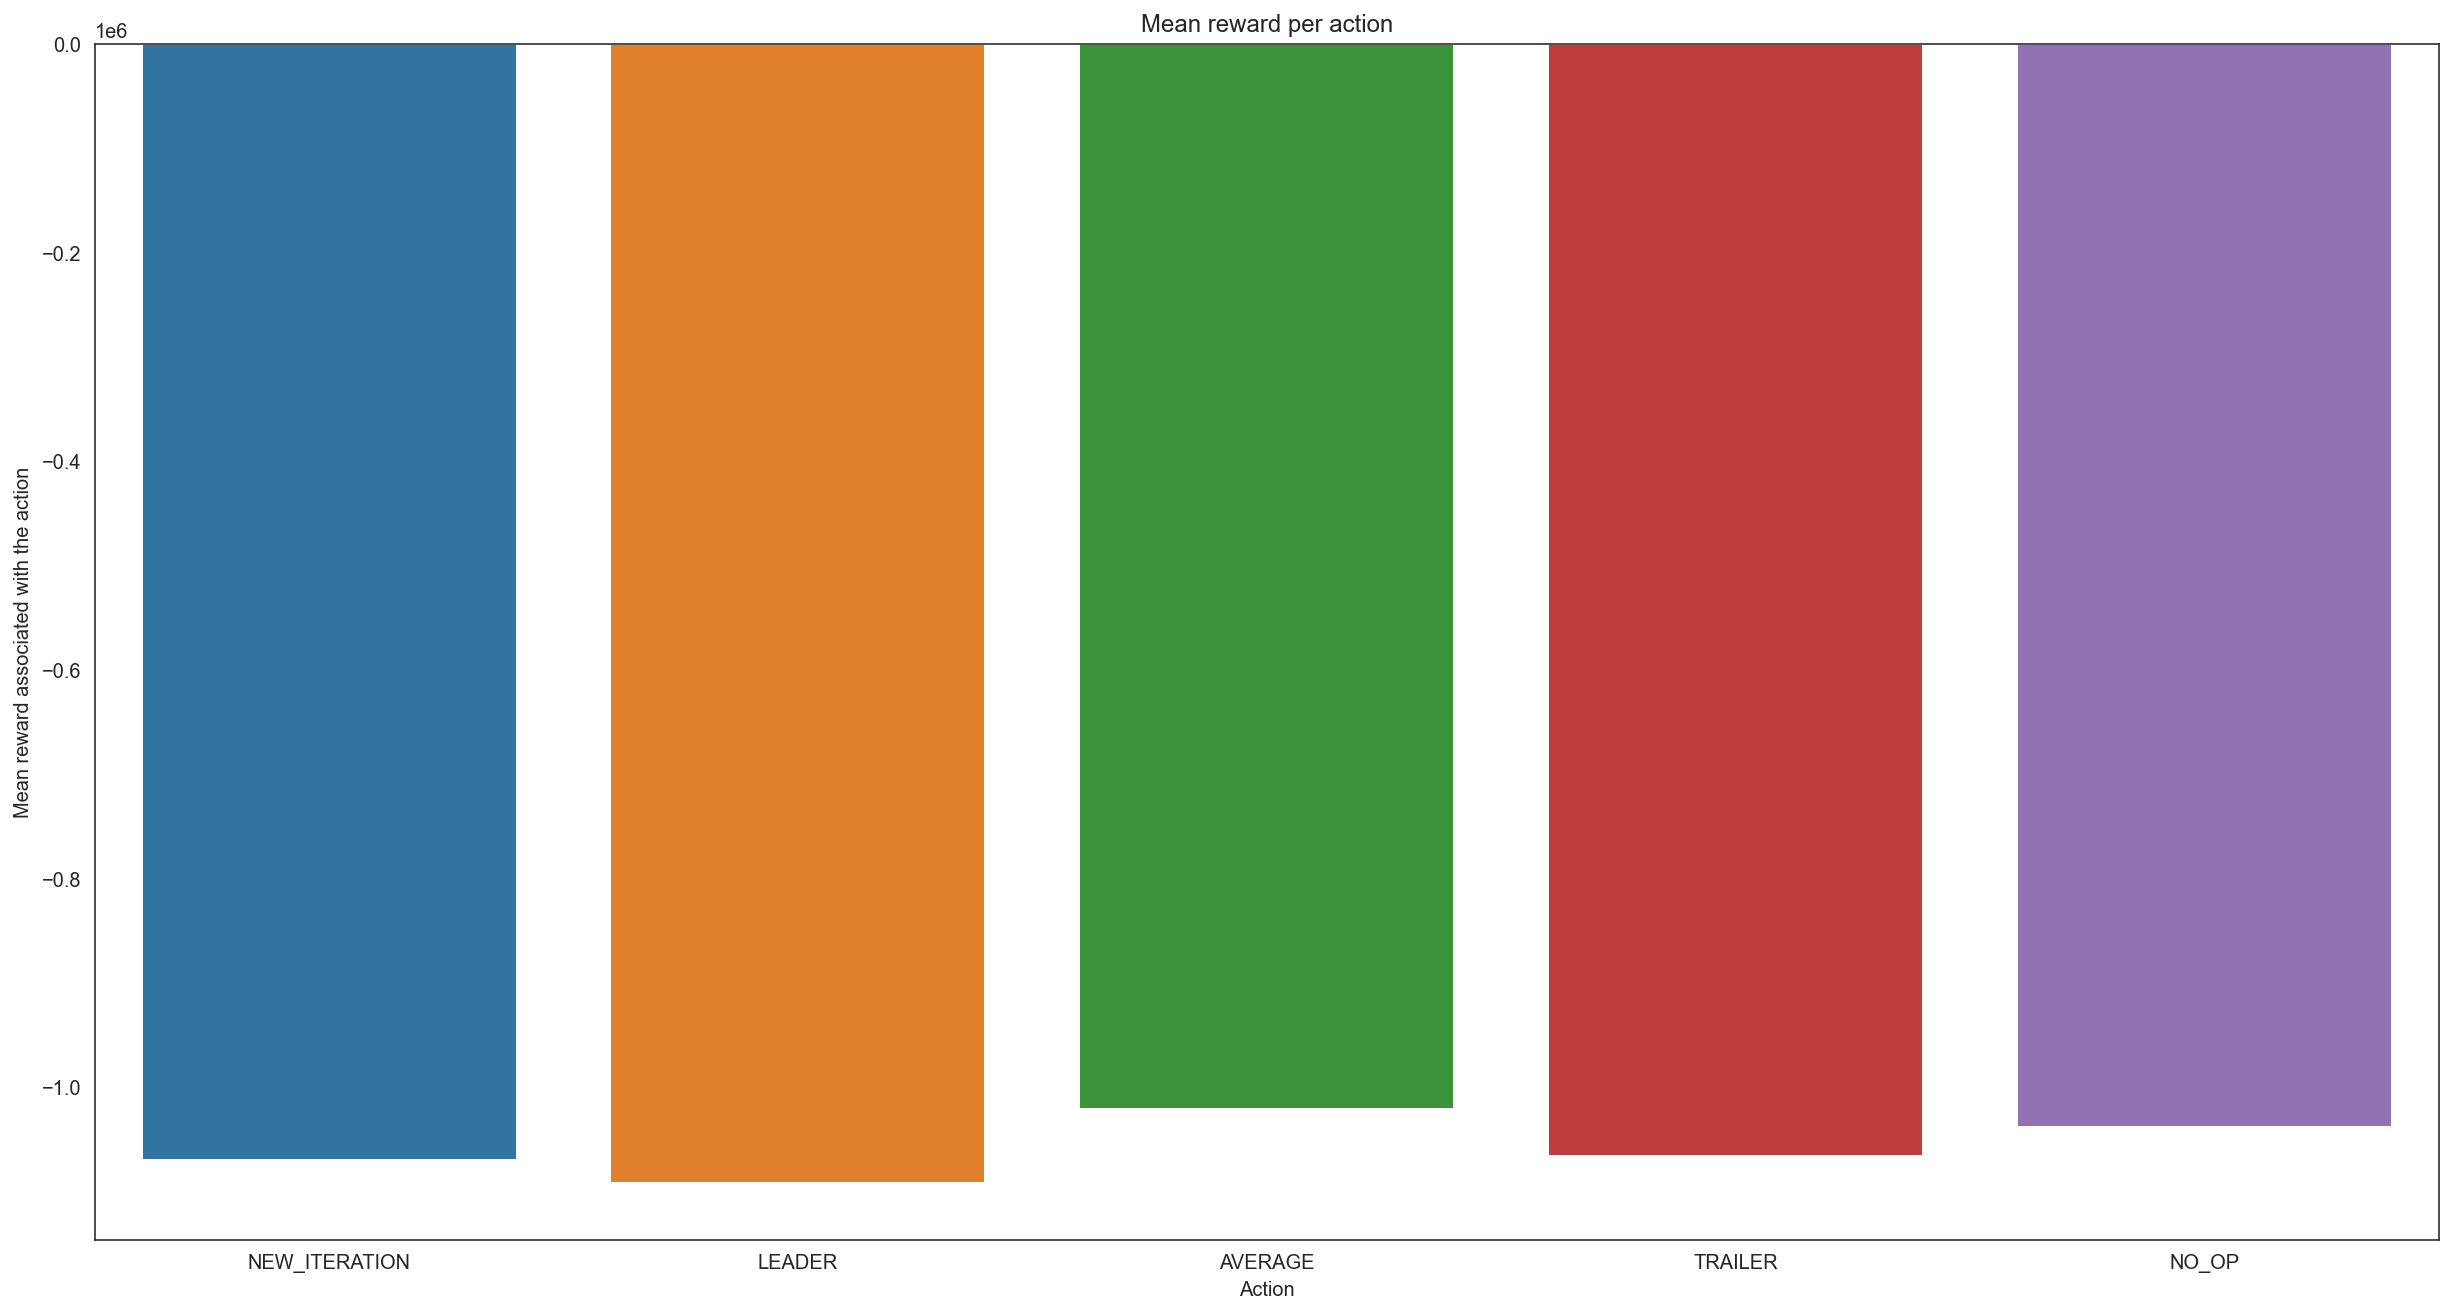

In [21]:
plot_mean_reward_per_action(df_reward)